## December 2025: Heavy Rain Falling on Burned Land

Stehkin, WA in the North Cascades had fire-burned land that resulted in debris flows during the atmpsoheric river event of December 2025. We have been asked to explore using APIs to get data related to this time period that can help to characterize these events. 

Some brainstorming ideas:
1. Get precip data 
2. Get streamgauge data
3. Explore historical context for reference


### Precipitation Data Exploration

The first site I exlored was found searching for weather APIs for Stehekin WA, which led me to weather.gov. I was able to locate station ID values, and retreive some data using their API keys, only to find that this site does not provide historical data into the past that could satiisfy the needs of this assignment. I did discover the following important information:

Location coordiates Stehekin, WA: 48.31, -120.66
Station ID: STRW1

With some help from AI prompts, I determined that using SNOTEL sites, which record snowfall and snow equivalent precipitation would be useful since Stehekin is a very remote area in the North Cascades with no ground monitoring precipitation gauges. After a web search for SNOTEL sites near our study area, I found the following useful information:

USDA has data for SNOTEL sites
Lyman Lake is the closest gauge, Site ID= 606
web page: https://wcc.sc.egov.usda.gov/nwcc/site?sitenum=606

By exploring this site. I was able to find cumulative daily precip data for the time period in question using this address:
https://wcc.sc.egov.usda.gov/awdbRestApi/swagger-ui/index.html#/Data/getData

I will now try and build some code blocks to work with this data, commenting as I go, and building a plot for daily rainfall from the cumulative values.


### Import Dependencies

In [4]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

### Define the API endpoint and query settings

In [5]:
BASE_URL = "https://wcc.sc.egov.usda.gov/awdbRestApi/services/v1/data"

# Station: Lyman Lake SNOTEL
# Triplet format = stationId:stateCode:networkCode
STATION_TRIPLET = "606:WA:SNTL"

# Element code:
# PREC in AWDB is typically a *cumulative precipitation* value (units: inches),
# so we will later convert it to daily precip by taking day-to-day differences.
ELEMENT = "PREC"

# Date range:
# Start one day early so we can compute Dec 1 daily precip correctly (diff needs a previous day)
START_DATE = "2025-11-30"
END_DATE   = "2025-12-31"

# Data duration (aggregation level)
DURATION = "DAILY"

def fetch_awdb_data(station_triplet: str,
                    element: str,
                    start_date: str,
                    end_date: str,
                    duration: str = "DAILY") -> dict:
    """
    Fetch data from the USDA NRCS AWDB REST API.

    Returns the parsed JSON (Python dict/list).
    """
    params = {
        "stationTriplets": station_triplet,
        "elements": element,
        "duration": duration,
        "startDate": start_date,
        "endDate": end_date,
        "format": "JSON",
    }

    r = requests.get(BASE_URL, params=params, timeout=30)
    r.raise_for_status()  # raises a helpful error if the request failed
    return r.json()

### Make the request and see if it works

In [4]:
payload = fetch_awdb_data(
    station_triplet=STATION_TRIPLET,
    element=ELEMENT,
    start_date=START_DATE,
    end_date=END_DATE,
    duration=DURATION
)

In [5]:
# Inspect what payload actually is
type(payload)

list

In [6]:
# Look at the first element of the list
payload[0]


{'stationTriplet': '606:WA:SNTL',
 'data': [{'stationElement': {'elementCode': 'PREC',
    'ordinal': 1,
    'durationName': 'DAILY',
    'dataPrecision': 1,
    'storedUnitCode': 'in',
    'originalUnitCode': 'in',
    'beginDate': '1979-07-16 00:00',
    'endDate': '2100-01-01 00:00',
    'derivedData': False},
   'values': [{'date': '2025-12-08', 'value': 28.3},
    {'date': '2025-12-09', 'value': 29.4},
    {'date': '2025-12-10', 'value': 34.0},
    {'date': '2025-12-11', 'value': 35.6},
    {'date': '2025-12-12', 'value': 36.0},
    {'date': '2025-12-13', 'value': 36.1},
    {'date': '2025-12-14', 'value': 36.2},
    {'date': '2025-12-15', 'value': 38.5},
    {'date': '2025-12-16', 'value': 40.6},
    {'date': '2025-12-17', 'value': 42.4},
    {'date': '2025-12-18', 'value': 44.1},
    {'date': '2025-12-19', 'value': 44.5},
    {'date': '2025-12-20', 'value': 45.5},
    {'date': '2025-12-21', 'value': 45.8},
    {'date': '2025-12-22', 'value': 46.3},
    {'date': '2025-12-23', 'va

In [7]:
values = payload[0]["data"][0]["values"]
values[:5]


[{'date': '2025-12-08', 'value': 28.3},
 {'date': '2025-12-09', 'value': 29.4},
 {'date': '2025-12-10', 'value': 34.0},
 {'date': '2025-12-11', 'value': 35.6},
 {'date': '2025-12-12', 'value': 36.0}]

### Now to trasnform the given cumulative rainfall measurements (inches) into daily precip values

In [3]:
import pandas as pd

# Convert the values list into a DataFrame
df = pd.DataFrame(values)
df["date"] = pd.to_datetime(df["date"])

# Convert cumulative precipitation to daily increments
df["daily_precip_in"] = df["value"].diff()

df


NameError: name 'values' is not defined

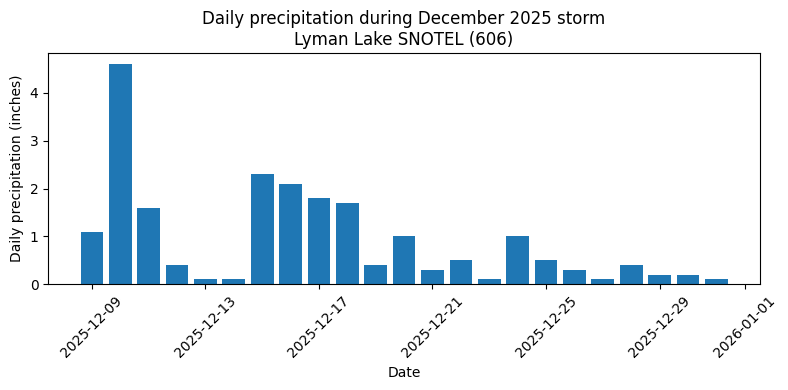

In [9]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(8, 4))
plt.bar(df["date"], df["daily_precip_in"])

# Labels and title
plt.xlabel("Date")
plt.ylabel("Daily precipitation (inches)")
plt.title("Daily precipitation during December 2025 storm\nLyman Lake SNOTEL (606)")

# Improve readability
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

### Precipitation Discussion

From the data obtained from the SNOTEL monitoring site near Stehekin, WA, the rainfall was unusually high starting on December 8th, peaking on December 9th, and eventually subsiding on December 11th before another significant rainfall event happening again a few days later. I will now move on to looking at stream gauge data to paint more of the picture. 

## Stream gauge data exploration

Exploring "water data using APIs" I discovered this site: https://waterdata.usgs.gov/nwis/uv?site_no=12451000&legacy=1 that provides the following important data:

Station: USGS 12451000
Stehekin River at Stehekin, WA
Flood stage= 24.0 ft

I was able to plot historical data to show where the stream exceeded flood stage twice, beginning on December 11th. Before using this available data, I wanted to see if I can use an API to pull this same data that is available through interactive tools on the USGS website. 

leave off here: https://api.waterdata.usgs.gov/ogcapi/v0/

This wasn't quite the correct pathway, going to use this:
https://waterservices.usgs.gov/nwis/iv/

This will be the base url for stream data, and I will build some code to retreive the data next. 


### Define USGS endpoint and query settings

In [6]:
# --- 2) Define the USGS API endpoint and query settings ---
BASE_URL = "https://waterservices.usgs.gov/nwis/iv/"

SITE_NO = "12451000"                 # your USGS gauge
START_DT = "2025-12-01"              # start date (YYYY-MM-DD)
END_DT   = "2026-01-16"              # end date (YYYY-MM-DD)

# USGS parameter codes:
# 00065 = gage height (stage)
# 00060 = discharge (streamflow)
PARAMETER_CD = "00065,00060"

### Fetch JSON data from the host

In [7]:
params = {
    "format": "json",              # request JSON output
    "sites": SITE_NO,              # gauge site number
    "startDT": START_DT,           # start date
    "endDT": END_DT,               # end date
    "parameterCd": PARAMETER_CD    # stage + discharge
}

response = requests.get(BASE_URL, params=params, timeout=30)
response.raise_for_status()        # stop immediately if something went wrong

payload = response.json()          # this is your raw JSON (like with SNOTEL)
type(payload)


dict

### Sanity check code block

In [8]:
# USGS instantaneous data are stored here:
time_series = payload["value"]["timeSeries"]

# How many separate time series did we get?
len(time_series)


2

In [9]:
# Print the variable names and units so we know which is which
for i, ts in enumerate(time_series):
    var_name = ts["variable"]["variableName"]
    unit = ts["variable"]["unit"]["unitCode"]
    print(f"{i}: {var_name} ({unit})")
    

0: Streamflow, ft&#179;/s (ft3/s)
1: Gage height, ft (ft)


### Convert stage time series to Dataframe

In [10]:
ts_stage = time_series[1]  # index 1 is "Gage height, ft"

# Grab the list of observations (each item has "value" and "dateTime")
stage_values = ts_stage["values"][0]["value"]

# Convert to a DataFrame
df_stage = pd.DataFrame(stage_values)

# Clean up types
df_stage["dateTime"] = pd.to_datetime(df_stage["dateTime"])
df_stage["stage_ft"] = pd.to_numeric(df_stage["value"], errors="coerce")

# Keep only the useful columns
df_stage = df_stage[["dateTime", "stage_ft"]].sort_values("dateTime").reset_index(drop=True)

# Quick look
df_stage.head()


,dateTime,stage_ft
0,2025-12-01 00:00:00-08:00,19.61
1,2025-12-01 00:15:00-08:00,19.61
2,2025-12-01 00:30:00-08:00,19.59
3,2025-12-01 00:45:00-08:00,19.60
4,2025-12-01 01:00:00-08:00,19.58


### Plot Stream Stage

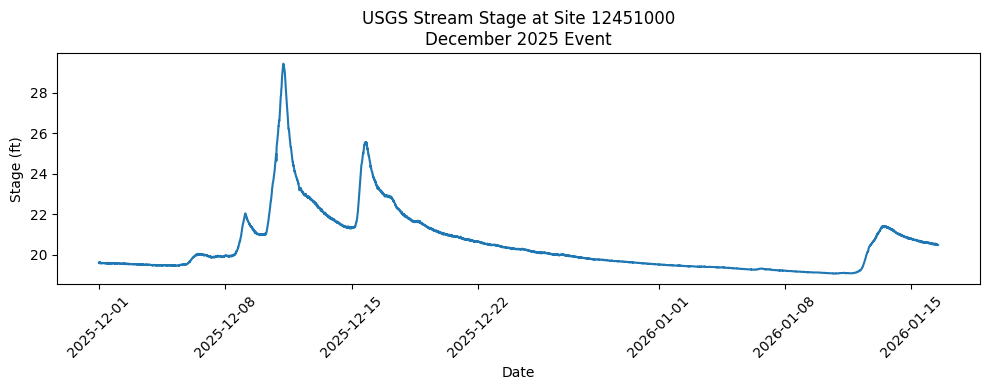

In [11]:
plt.figure(figsize=(10, 4))
plt.plot(df_stage["dateTime"], df_stage["stage_ft"])

plt.xlabel("Date")
plt.ylabel("Stage (ft)")
plt.title("USGS Stream Stage at Site 12451000\nDecember 2025 Event")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()